<a href="https://colab.research.google.com/github/mburkasov/Financial-forecasting/blob/main/Case_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import requests
import sklearn

from lightgbm import LGBMClassifier
from sklearn import ensemble
from datetime import datetime
from google.colab import drive
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.neural_network import MLPClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [23]:
excel = requests.get('https://drive.google.com/u/0/uc?id=1l5vsiKJmVH15eMxm1RDH_OtcDX7qfHYu&export=download')
df1 = pd.read_excel(excel.content)

In [24]:
def export_prediction(pred, filename = 'output'):
  drive.mount('/content/drive')
  pred=pd.DataFrame(pred)
  pred.to_excel(f'/content/drive/My Drive/Colab Notebooks/{filename}.xlsx')

def getvif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  X = np.array(X, dtype = float)
  vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
  vif = vif.sort_values(by=['VIF'], ascending=False)
  if vif.iloc[0,0] == 'const':
    vif = vif.iloc[1:]
  return vif

In [25]:
df = df1.copy()

if 'claimid' in df.columns:
  df.pop('claimid')
if 'policyid' in df.columns:
  df.pop('policyid')

if df['deductible'].max() > 10:
  df['deductible'] = (df['deductible']//100)/10

if 'fraudulent' in df.columns:
  target = df.pop('fraudulent')
  df.insert(0,'target',target)

In [26]:
today = datetime(2009,1,1)
#make days into int
dates = (df.select_dtypes(include='datetime')).columns
for column in dates:
  df[column] = (today - df[column]).dt.days
#dates = dates.drop('dob', axis=1)
#for column in dates:
#  df[column] =  df['dob'] - df[column]
#datedf = df[dates.columns]
dates

Index(['incident_date', 'policy_date', 'dob', 'job_start_date',
       'occupancy_date'],
      dtype='object')

In [27]:
category = []
unique = df.nunique()
for i in range(len(unique)):
  if unique[i] < 10:
    category.append(unique.index[i])
catdf = df[category]
discrete = set(df.columns) - set(category)# - set(dates)
discrete.update({'deductible'})
discdf = df[discrete]

In [28]:
scaler = MinMaxScaler()
scaler.fit(discdf)
discdf = pd.DataFrame(scaler.transform(discdf), columns=discdf.columns)

for column in discdf:
  df[column] = discdf[column]

In [29]:
crit = 10
poplist = []

X = df.iloc[0:-1000,1:]
X = sm.add_constant(X)

vif = getvif(X)
while vif.iloc[0,1]>crit:
  poplist.append(vif.iloc[0,0])
  X.pop(vif.iloc[0,0])
  vif = getvif(X)

print('popped:',poplist)
df = df.drop(poplist, axis=1)

popped: ['occupancy_date']


In [30]:
Y = df.iloc[:-1000,0]
X = df.iloc[:-1000,1:]

k = 6

bestfeatures = SelectKBest(score_func=f_classif, k=k)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score'))

#list1 = featureScores.nlargest(k,'Score').iloc[:,0].tolist()
#featlist = featureScores.nlargest(k,'Score')


bestfeatures = SelectKBest(score_func=chi2, k=k)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score'))

#list2 = featureScores.nlargest(k,'Score').iloc[:,0].tolist()
featlist = featureScores.nlargest(k,'Score')


#featlist = pd.concat([featlist, featureScores.nlargest(k,'Score')])
#featlist = featlist.sort_values('Score',ascending = False).drop_duplicates(subset=['Feature'], keep='first')

           Feature      Score
11  job_start_date  11.977580
9              dob  11.120955
4      policy_date   9.965558
1       claim_type   8.202302
13          income   7.700146
8           gender   2.576086
           Feature     Score
1       claim_type  6.347413
11  job_start_date  1.993958
2    uninhabitable  1.820110
9              dob  1.775115
4      policy_date  1.544936
8           gender  1.268593


In [31]:
crit = 1.5
featlist = featlist.sort_values('Score',ascending = False).drop_duplicates(subset=['Feature'], keep='first')
finallist = featlist[featlist['Score']>crit]['Feature'].tolist() 
finallist

['claim_type', 'job_start_date', 'uninhabitable', 'dob', 'policy_date']

In [32]:
features = ['target'] + finallist

train = df[features].iloc[:-1500]
test = df[features].iloc[-1500:-1000]
pred = df[features].iloc[-1000:,1:]

#test = df[features].iloc[-1000:]


alltrain = df[features].iloc[:-1000]

In [33]:
y = train.iloc[:,0]
x = train.iloc[:,1:]
y1 = test.iloc[:,0]
x1 = test.iloc[:,1:]
y2 = alltrain.iloc[:,0]
x2 = alltrain.iloc[:,1:]
x=sm.add_constant(x)
x1=sm.add_constant(x1)
x2=sm.add_constant(x2)
pred=sm.add_constant(pred)



In [ ]:
#logit
logit_model = sm.Logit(y,x).fit()
prediction=logit_model.predict(x1)

logit_roc_auc=roc_auc_score(y1, prediction)
fpr,tpr,thresholds=roc_curve(y1, prediction)

logit_model = sm.Logit(y2,x2).fit()
prediction = logit_model.predict(pred)
export_prediction(prediction)

#random forest
rf = sklearn.ensemble.RandomForestClassifier().fit(x,y)
prediction1=rf.predict_proba(x1)[:,1]

logit_roc_auc1=roc_auc_score(y1,prediction1)
fpr1,tpr1,thresholds1=roc_curve(y1,prediction1)
#gradient boosting
gb=sklearn.ensemble.GradientBoostingClassifier().fit(x,y)
prediction2 = gb.predict_proba(x1)[:,1]

logit_roc_auc2 = roc_auc_score(y1,prediction2)
fpr2,tpr2,thresholds2=roc_curve(y1,prediction2)
#MLPClassifier
nn = MLPClassifier(activation='logistic')

nn=nn.fit(x,y)
prediction3=nn.predict_proba(x1)[:,1]

logit_roc_auc3=roc_auc_score(y1,prediction3)
fpr3,tpr3,thresholds3=roc_curve(y1,prediction3)
#MLPClassifier
from lightgbm import LGBMClassifier

clf2 = LGBMClassifier()
clf2.fit(x, y)

prediction4 = clf2.predict_proba(x1)[:, 1]

logit_roc_auc4=roc_auc_score(y1,prediction4)
fpr4,tpr4,thresholds4=roc_curve(y1,prediction4)

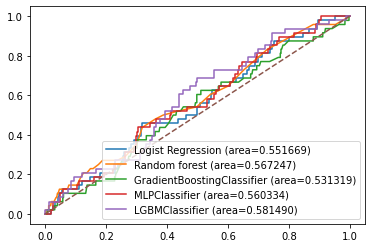

In [36]:
plt.plot(fpr,tpr,label = 'Logist Regression (area=%0.6f)' % logit_roc_auc)
plt.plot(fpr1,tpr1,label = 'Random forest (area=%0.6f)' % logit_roc_auc1)
plt.plot(fpr2,tpr2,label = 'GradientBoostingClassifier (area=%0.6f)' % logit_roc_auc2)
plt.plot(fpr3,tpr3,label = 'MLPClassifier (area=%0.6f)' % logit_roc_auc3)
plt.plot(fpr4,tpr4,label = 'LGBMClassifier (area=%0.6f)' % logit_roc_auc4)


t=np.linspace(0,1,10)
plt.plot(t,t,linestyle='dashed')
plt.legend()